In [1]:
# Title: (title)
# Author: (could be `Authors`: as well, and may contain markdown links)
# Date created: (date in yyyy/mm/dd format)
# Last modified: (date in yyyy/mm/dd format)
# Description: (one-line text description)

import os
import zipfile

from tensorflow import keras
from tensorflow.keras import layers

Cancer detection using CT scans, the goal is to identify locations (left or right) of possible cancerous regions by assigning a probability for each location.

In [2]:
!wget https://www.dropbox.com/s/h95yl68a26tehcq/NSCLC-Radiomics-Genomics.zip

--2020-09-17 19:14:49--  https://www.dropbox.com/s/h95yl68a26tehcq/NSCLC-Radiomics-Genomics.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h95yl68a26tehcq/NSCLC-Radiomics-Genomics.zip [following]
--2020-09-17 19:14:49--  https://www.dropbox.com/s/raw/h95yl68a26tehcq/NSCLC-Radiomics-Genomics.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e4b9210f0d9319beba176137f.dl.dropboxusercontent.com/cd/0/inline/A_mdXx6YG9U5rgXTCJlVtgaLCJCNfNgtmQcW7Q2ITM2HTrQN7oQpO2lADKeBQu7vv9ck6hZG90W_YqRCNlcDWu1Z-P-l8Gfo6ZDp5B3x-r89vlHsMZq00-1qZ6L2xFAz8vM/file# [following]
--2020-09-17 19:14:49--  https://uc8e4b9210f0d9319beba176137f.dl.dropboxusercontent.com/cd/0/inline/A_mdXx6YG9U5rgXTCJlVtgaLCJCNfNgtmQcW7Q2ITM2HTrQN7oQpO2lADKeBQu7

In [3]:
with zipfile.ZipFile("NSCLC-Radiomics-Genomics.zip", "r") as z_fp:
    z_fp.extractall("./")

In [2]:
import cv2
import numpy   as np
import nibabel as nib
from scipy.ndimage import zoom

# The files are provided in Nifti format (*.nii). To read in the scans, we will use the nibabel package
# Volumes are originally rotated, so we use np.rot90 to fix the orientation.

def read_nifti_file(filepath):
    """
    Reads a *.nii file and return the volume as a numpy array.

    Args:
      path : path of the *.nii file

    Returns
      Numpy array of the 3D volume
    """

    scan = nib.load(filepath)
    scan   = scan.get_fdata()

    scan   = np.rot90(np.array(scan))
    return scan


def rs_img(img):
    flatten = [cv2.resize(img[:,:,i], (128, 128), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten)) 
    return img


def resize_ct_scan(img):
    desired_depth = 128
    current_depth = img.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (1, 1, depth_factor), mode='nearest')
    return img_new


# The radiointensity values currently range from -1024 to above 2000. 
# Above 400 are bones with different radiointensity, so we use that a higher bound.
# We use a threshold between -1000 and 400 to normalize the scans.
# These thresholds are commonly used in CT scans, such as in the LUNA16 competition. 
def normalize(array):
    min = -1000
    max = 400 
    array = (array - min) / (max - min)
    array[array>1] = 1.
    array[array<0] = 0.
    return array


def process_scan(path):

  # Read scan
  volume = read_nifti_file(path)
  # Resize width and height
  volume = rs_img(volume)
  # Resize depthwise
  volume = resize_ct_scan(volume)
  # Normalize
  volume = normalize(volume)
  return volume


In [3]:
right_scan_paths = [os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/1", x) for x in os.listdir("NSCLC-Radiomics-Genomics/1")]
left_scan_paths = [os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/2", x) for x in os.listdir("NSCLC-Radiomics-Genomics/2")]
print(len(right_scan_paths), len(left_scan_paths))

49 40


Dimension of the CT scan is: (512, 512, 227)


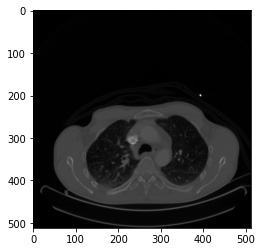

In [4]:
import matplotlib.pyplot as plt

img = read_nifti_file(right_scan_paths[5])
print("Dimension of the CT scan is:", img.shape)
plt.imshow(img[:,:,150], cmap="gray")

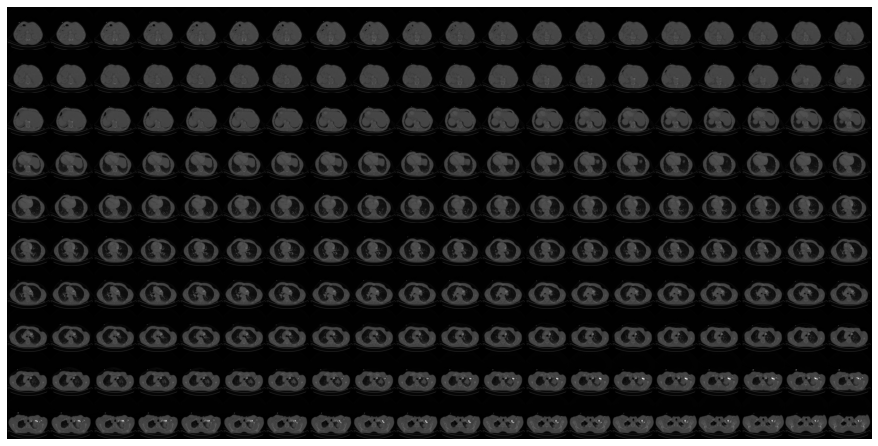

In [5]:
def plot_slices(data):
    a, b = 10, 20
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (a, b, 512, 512))
    test_data = data
    r, c = test_data.shape[0], test_data.shape[1]
    
    heights = [a[0].shape[0] for a in test_data]
    widths = [a.shape[1] for a in test_data[0]]

    fig_width = 12.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
          gridspec_kw={'height_ratios':heights})

    for i in range(r):
        for j in range(c):
            axarr[i, j].imshow(test_data[i][j], cmap='gray')
            axarr[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# A montage of the slices in a CT scan
plot_slices(img[:,:,:200])

In [6]:
# Read and process the scans
right_scans=np.array([process_scan(path) for path in right_scan_paths])
left_scans=np.array([process_scan(path) for path in left_scan_paths])

# Assign labels
# For the CT scans having cancerous regions in the right side, we assign 1,
# similarly for left we assign 0.
right_labels = np.array([1 for _ in range(len(right_scans))])
left_labels = np.array([0 for _ in range(len(left_scans))])

# Merge classes
inputs = np.concatenate((right_scans, left_scans), axis=0)
labels = np.concatenate((right_labels, left_labels), axis=0)
labels = keras.utils.to_categorical(labels, 2)
print("Size of raw data and labels:", inputs.shape, labels.shape)

# Split data in the ratio 80-20 for training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.3, random_state=1)
print("After train and test split:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Size of raw data and labels: (89, 128, 128, 128) (89, 2)
After train and test split: (62, 128, 128, 128) (62, 2) (27, 128, 128, 128) (27, 2)


In [9]:
import random 

from scipy import ndimage
from scipy.ndimage import gaussian_filter

def rotate(volume):
  volume = ndimage.rotate(volume, 10, reshape=False)
  return volume


def blur(volume):
  volume = gaussian_filter(volume, sigma=1)
  return volume


def rotate_and_blur(volume):
  volume = ndimage.rotate(volume, 5, reshape=False)
  volume = gaussian_filter(volume, sigma=1)
  return volume


def augment_data(volume, label, func_name):
  volume = func_name(volume)
  return volume, label


def get_augmented_data(inputs, labels):
  x_train_aug = []
  y_train_aug = []

  # Rotate all scans
  for volume, label in zip(inputs,labels):
    volume, label = augment_data(volume, label, rotate)
    x_train_aug.append(volume)
    y_train_aug.append(label)

  # Gaussian Blur all scans
  for volume, label in zip(inputs,labels):
    volume, label = augment_data(volume, label, blur)
    x_train_aug.append(volume)
    y_train_aug.append(label)

  x_train_aug = np.array(x_train_aug)
  y_train_aug = np.array(y_train_aug)
  return x_train_aug, y_train_aug

In [10]:
x_train_aug, y_train_aug = get_augmented_data(x_train, y_train)
print(x_train_aug.shape, y_train_aug.shape)

(124, 128, 128, 128) (124, 2)


In [11]:
# Merge raw data and augmented data
x_all = np.concatenate((x_train_aug, x_train), axis=0)
x_all = np.expand_dims(x_all, axis=4)
y_all = np.concatenate((y_train_aug, y_train), axis=0)
print(x_all.shape, y_all.shape)

(186, 128, 128, 128, 1) (186, 2)


In [12]:
# Clear up some RAM
left_scans = None
right_scans = None
inputs = None
x_train = None
x_train_aug = None

In [13]:
def get_model(img_size, num_classes):
  """
  Build a 3D Convolutional Neural Network model

  Args:
    img_size : size of input
    num_classes : number of output classes

  Returns
    3D CNN model 
  """
  
  inputs = keras.Input(img_size)

  x = layers.Conv3D(filters=32, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)  

  x = layers.Conv3D(filters=32, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  #x = layers.Conv3D(filters=512, kernel_size=3, activation='relu')(x)
  #x = layers.MaxPool3D(pool_size=2)(x)
  #x = layers.BatchNormalization()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(units=512, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  #x = layers.Dense(units=256, activation='relu')(x)
  #x = layers.BatchNormalization()(x)
  #x = layers.Dropout(0.2)(x)

  outputs = layers.Dense(units=2, activation='softmax')(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((128, 128, 128, 1), 2)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 126, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 63, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 63, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 61, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 30, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 30, 32)   

In [14]:
# Compile model
# We use the "binary_crossentropy"
# for the binary classification problem
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.Adam(1e-5), metrics=["acc"]) 

callbacks = [
    keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=8)
]

# Train the model, doing validation at the end of each epoch.
epochs=300
model.fit(x_all,y_all,validation_data=(x_test,y_test),
          batch_size=2, epochs=epochs, 
          shuffle=True, verbose=2,
          callbacks=callbacks)

Epoch 1/300
93/93 - 17s - loss: 0.9938 - acc: 0.5860 - val_loss: 0.7023 - val_acc: 0.4444
Epoch 2/300
93/93 - 16s - loss: 0.3959 - acc: 0.8333 - val_loss: 0.6945 - val_acc: 0.5556
Epoch 3/300
93/93 - 16s - loss: 0.1943 - acc: 0.9462 - val_loss: 0.6787 - val_acc: 0.6296
Epoch 4/300
93/93 - 16s - loss: 0.1385 - acc: 0.9570 - val_loss: 0.8865 - val_acc: 0.4444
Epoch 5/300
93/93 - 16s - loss: 0.0888 - acc: 0.9892 - val_loss: 0.7419 - val_acc: 0.4815
Epoch 6/300
93/93 - 16s - loss: 0.0817 - acc: 0.9677 - val_loss: 0.7271 - val_acc: 0.5556
Epoch 7/300
93/93 - 16s - loss: 0.0662 - acc: 0.9785 - val_loss: 0.8354 - val_acc: 0.5185
Epoch 8/300
93/93 - 16s - loss: 0.0514 - acc: 0.9892 - val_loss: 0.8018 - val_acc: 0.6667
Epoch 9/300
93/93 - 16s - loss: 0.0272 - acc: 1.0000 - val_loss: 0.9067 - val_acc: 0.5926
Epoch 10/300
93/93 - 16s - loss: 0.0276 - acc: 1.0000 - val_loss: 0.8677 - val_acc: 0.6667
Epoch 11/300
93/93 - 16s - loss: 0.0214 - acc: 1.0000 - val_loss: 0.8640 - val_acc: 0.6296
Epoch 12

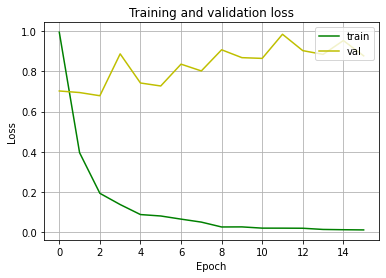

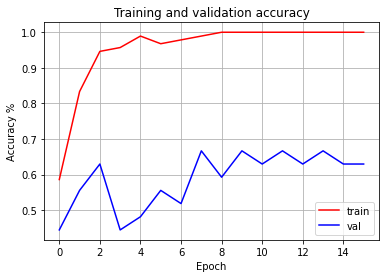

In [15]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.show()
    
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.show()

plot_loss_accu(model.history)